In [1]:
# --- Import required packages
import pathlib
import pandas as pd
import numpy as np
from itertools import combinations
import os
from tqdm import tqdm
import requests
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
import platform

# Import helper functions
from logit_demand_functions import *

# Warnings and display
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)

In [2]:
# --- Set paths ----------------
if platform.platform()[0:5] == 'macOS':
    cd = pathlib.Path().resolve().parent.parent
    str_project = cd / "Documents" 
    data_path = cd / "Documents" / "tobin_working_data"
    rlpolk_data_path = data_path / "rlpolk_data"
    vin_matching_path =  data_path / "vin_matching"
    data_one_vins_path = data_path / "vin_decoder"
else:
    data_path = pathlib.Path().resolve().parent.parent / "rn_home" / "data"
    rlpolk_data_path = data_path / "rlpolk_data"
    vin_matching_pathpackages= data_path / "vin_matching"

In [301]:
# --- Import RLPolk Data (partially matched) ------
rlp_raw = pd.read_csv(rlpolk_data_path / "rlpolk_data_matched.csv", index_col = [0])
evs_only = rlp_raw[rlp_raw["Fuel Type - Primary"] == "Electric"].reset_index(drop = True)
ev_vins = evs_only["vin_corrected"].unique().tolist()

# Make the rlp raw column names lower case
rlp_raw.columns = [x.lower() for x in rlp_raw.columns]

# Drop duplicated rlp columns
rlp_raw = rlp_raw.loc[:,~rlp_raw.columns.duplicated()]


In [ ]:
# --- Import Experian Data
# exp_data = pd.read_csv(data_path / "intermediate" / "US_VIN_data_common.csv")
# exp_ct = exp_data[exp_data["state"]=="CONNECTICUT"]
# exp_ct_ev = exp_ct[exp_ct["fueltype"]=="L"]

# Download VIN characteristics from NHTSA

In [10]:
# Download some characteristics and show what we get - mostly NA
if (True):
    ev_chars = pd.DataFrame([])

    for vin in tqdm(ev_vins):
        # vin = row["vin_corrected"]
        try:
            chars = fetch_vin_data(vin)
            # print(len(chars.columns))
        except:
            pass
        try:   
            ev_chars = pd.concat([ev_chars, chars], axis = 0).reset_index(drop = True)
        except:
            pass


    ev_chars.to_csv(rlpolk_data_path / "rlp_ev_characteristics_012624.csv")

# Check EV sales per model year
rlp_evs_summary = evs_only[["year", "VEH_COUNT"]].groupby("year").sum().reset_index()
# exp_evs_summary = exp_ct_ev[["year", "agg_count"]].groupby("year").sum().reset_index()
print(rlp_evs_summary.head(10))
# print(exp_evs_summary.head(10))
print(rlp_evs_summary.iloc[0:6, 0].sum())

100%|██████████| 712/712 [02:23<00:00,  4.95it/s]


   year  VEH_COUNT
0  2018       4571
1  2019       4042
2  2020       3660
3  2021       8461
4  2022      10046
10100


# Attempt match with DataOne Matcher

In [3]:
# Import RLP data
rlp_raw = pd.read_csv(rlpolk_data_path / "rlpolk_data_matched.csv", index_col = [0])

# Import DataOne Data
d1_vins = pd.read_csv(data_one_vins_path / "VIN_REFERENCE.csv")
d1_vins["d1_merge"] = 1
d1_prices = pd.read_csv(data_one_vins_path / "VEH_PRICE.csv")

# Merge d1_prices and d1_vins on vehicle id
d1_vins = d1_vins.merge(d1_prices, on = "vehicle_id", how = "left")

# Make all the columns in RLP data lower case and drop the duplicate columns
rlp_raw.columns = [x.lower() for x in rlp_raw.columns]
rlp_raw = rlp_raw.loc[:,~rlp_raw.columns.duplicated()]

# Create a column in rlp that is 1 if the transaction_price is missing, and 0 otherwise
rlp_raw["rlp_missing_price"] = rlp_raw["transaction_price"].isna().astype(int)

# Create a column in rlp that is 1 if the transaction price is below 10000 and 0 otherwise
rlp_raw["rlp_low_price"] = (rlp_raw["transaction_price"] < 10000).astype(int)

In [4]:
# Confirm lengths align
print(f"All RLP VINS are {rlp_raw.vin_prefix.str.len().unique().tolist()[0]} long")
print(f"All DataOne VINS are {d1_vins.vin_pattern.str.len().unique().tolist()[0]} long")

All RLP VINS are 10 long
All DataOne VINS are 10 long


In [5]:
# Provide breakdown of how many in RLP have missing price
print(rlp_raw["rlp_missing_price"].value_counts())

# Provide breakdown of how many in RLP have low price
print(rlp_raw["rlp_low_price"].value_counts())

rlp_missing_price
0    672478
1    251999
Name: count, dtype: int64
rlp_low_price
0    902596
1     21881
Name: count, dtype: int64


In [54]:
# Drop those in RLP with a missing or low price
rlp_raw_filtered = rlp_raw[(rlp_raw["rlp_missing_price"] == 0) & (rlp_raw["rlp_low_price"] == 0)].reset_index(drop = True)

In [56]:
# Prepare for match
rlp_raw_filtered["vin_d1_match"] = rlp_raw.loc[:, "vin_prefix"].str[0:8] + rlp_raw.loc[:, "vin_prefix"].str[9]
d1_vins["vin_rlp_match"] = d1_vins["vin_pattern"].str[0:9]

In [33]:
# Do a fuzzy match first on vins and then on msrp and transaction price
def fuzzy_match(vin, price, df_match_from, keycol, pricecol, other_cols):
    try:
        possible_matches = df_match_from.loc[df_match_from[keycol]==vin, :]
        # display(possible_matches)
        # print((possible_matches[pricecol]-price).abs().argsort()[:1].index.tolist()[0])
        closest_row = df_match_from.iloc[[(possible_matches[pricecol]-price).abs().argsort()[:1].index.tolist()[0]], :]
        return closest_row
    except:
        return None
0

0

In [46]:
closest_matches = pd.DataFrame([])

for index, row in tqdm(rlp_raw_filtered.iterrows()):
    if index < 100:
        try:
            match = fuzzy_match(row.vin_d1_match, row.transaction_price, d1_vins, "vin_rlp_match", "msrp", ["vin_rlp_match", "msrp"])
            closest_matches = pd.concat([closest_matches, match], axis = 0)
        except:
            pass
    else:
        break

100it [00:00, 106.69it/s]


In [47]:
closest_matches

,vin_id,vehicle_id,vin_pattern,year,make,model,trim,style,mfr_model_num,mfr_package_code,...,brake_system,country_of_mfr,plant,d1_merge,veh_price_id,msrp,invoice,dest,gas_guzzler_tax,vin_rlp_match
182823,300077693,400905509,2HKRW6H3KH,2019,Honda,CR-V,LX,AWD LX 4dr SUV,RW6H3KEW,NaN,...,Hydraulic,Canada,"Alliston, Ontario, Canada",1,300205966,25850,24273,1095,0,2HKRW6H3K
181966,300076792,400905167,2HGFC2F6KH,2019,Honda,Civic,LX,LX 4dr Sedan CVT,FC2F6KEW,NaN,...,Hydraulic,Canada,"Alliston, Ontario, Canada",1,300205872,20350,18915,930,0,2HGFC2F6K
181157,300075950,400901737,3KPF24ADKE,2019,Kia,Forte,FE,FE 4dr Sedan 6M,C3411,NaN,...,Hydraulic,Mexico,"Monterrey, Mexico",1,300194536,17790,17168,925,0,3KPF24ADK
194828,300090449,400909528,2T2YGMDALC,2020,Lexus,RX 450h,F SPORT Performance,AWD F SPORT Performance 4dr SUV,9447,NaN,...,Hydraulic,Canada,"Cambridge, Ontario, Canada",1,300230075,52920,49743,1025,0,2T2YGMDAL
182823,300077693,400905509,2HKRW6H3KH,2019,Honda,CR-V,LX,AWD LX 4dr SUV,RW6H3KEW,NaN,...,Hydraulic,Canada,"Alliston, Ontario, Canada",1,300205966,25850,24273,1095,0,2HKRW6H3K
178747,300073439,400903986,5NMS3CADKH,2019,Hyundai,Santa Fe,SEL 2.4L,AWD SEL 2.4L 4dr Crossover,64422A45,01,...,Hydraulic,United States,"Montgomery, Alabama",1,300226480,29300,27956,1095,0,5NMS3CADK
182845,300077715,400904091,1GTU9AEFKZ,2019,GMC,Sierra 1500,Base,4x4 Base 4dr Crew Cab 5.8 ft. SB,TK10543,1SA,...,Hydraulic,United States,"Fort Wayne, Indiana",1,300200728,39200,37514,1595,0,1GTU9AEFK
182970,300077850,400905498,2T3F1RFVKW,2019,Toyota,RAV4,LE,AWD LE 4dr SUV,4432,NaN,...,Hydraulic,Canada,"Woodstock, Ontario, Canada",1,300221762,27050,25292,1120,0,2T3F1RFVK
172665,300066519,400901125,1N4AA6APJC,2018,Nissan,Maxima,3.5 S,3.5 S 4dr Sedan,16118,NaN,...,Hydraulic,United States,"Smyrna, Tennessee",1,300194001,33420,31202,895,0,1N4AA6APJ
181325,300076126,400904763,1C4HJXDNKW,2019,Jeep,Wrangler Unlimited,Sport,4x4 Sport 4dr SUV,JLJL74,NaN,...,Hydraulic,United States,Toledo North: Toledo Ohio,1,300180643,31545,31007,1495,0,1C4HJXDNK


In [309]:
# Test overlap
d1_vin_list = d1_vins.vin_pattern.unique().tolist()
rlp_vin_list = rlp_raw.vin_prefix.unique().tolist()
overlap = []

In [307]:
# Compare them
print(sorted(d1_vin_list, reverse = True)[0:5])
print(sorted(rlp_vin_list, reverse=True)[0:5])

['ZPBUA1ZLLL', 'ZPBUA1ZLKL', 'ZN661ZUTNX', 'ZN661ZUMNX', 'ZN661ZUAMX']
['ZPBUA1ZLXN', 'ZPBUA1ZLXM', 'ZPBUA1ZLXK', 'ZPBUA1ZL9N', 'ZPBUA1ZL9M']


Therefore these VINs seem similar, and same length.

In [271]:
# Compare similar makes and models
d1_vins.loc[(d1_vins.year == 2022) & (d1_vins.make=="Honda") & (d1_vins.model == "Odyssey"), "vin_pattern"].unique()

array(['5FNRL6H7NB', '5FNRL6H9NB', '5FNRL6H8NB', '5FNRL6H5NB',
       '5FNRL6H2NB'], dtype=object)

In [272]:
rlp_raw.loc[(rlp_raw.MODEL_YEAR == 2022) & (rlp_raw.MAKE == "HONDA") & (rlp_raw.MODEL == "ODYSSEY"), "VIN_PREFIX"].unique()[0:5]

array(['5FNRL6H77N', '5FNRL6H70N', '5FNRL6H72N', '5FNRL6H87N',
       '5FNRL6H78N'], dtype=object)

OK, now becomes easier to match

In [310]:
rlp_raw["vin_d1_match"] = rlp_raw.loc[:, "vin_prefix"].str[0:8] + rlp_raw.loc[:, "vin_prefix"].str[9]
d1_vins["vin_rlp_match"] = d1_vins["vin_pattern"].str[0:9]

# Note, that doing this creates duplicates in the d1_vins
d1_vins_dedup = d1_vins.drop_duplicates("vin_rlp_match")

# Now we show the data we have lost
print(f"The length of the d1_vins DF goes from {len(d1_vins)} to {len(d1_vins_dedup)}")

The length of the d1_vins DF goes from 203021 to 101457


In [323]:
# Where the rlp transaction price is low, get the transaction price from d1_vins and put it in another column
rlp_raw["d1_price"] = np.nan
rlp_raw.loc[rlp_raw["rlp_low_price"]==1, "d1_price"] = rlp_raw.loc[rlp_raw["rlp_low_price"]==1, "vin_d1_match"].map(d1_vins_dedup.set_index("vin_rlp_match")["msrp"])

# Check the results
rlp_raw[["d1_price", "transaction_price", "rlp_low_price"]].sort_values("transaction_price", ascending = True).head(10)

,rlp_low_price
d1_price_not_na,
0,1399
1,20482


In [327]:
# Wheret the transaction price is missing, get the transaction price from d1_vins and put it in another column
rlp_raw["d1_price_missing"] = np.nan
rlp_raw.loc[rlp_raw["rlp_missing_price"]==1, "d1_price_missing"] = rlp_raw.loc[rlp_raw["rlp_missing_price"]==1, "vin_d1_match"].map(d1_vins_dedup.set_index("vin_rlp_match")["msrp"])

# Create a temporary DF that has a 1 where the d1 price is not NA and 0 otherwise
rlp_raw["d1_missing_price_not_na"] = (~rlp_raw["d1_price_missing"].isna()).astype(int)

# Show breakdown of low price entries by whether or not d1 price is NA
rlp_raw[["d1_missing_price_not_na", "rlp_missing_price"]].groupby("d1_missing_price_not_na").sum()


,rlp_missing_price
d1_missing_price_not_na,
0,17785
1,234214


In [329]:
# Create a column called updated_price that contains the transaction_price if price is not low and not missing, and the d1_price otherwise
rlp_raw["updated_price"] = rlp_raw["transaction_price"]
rlp_raw.loc[rlp_raw["rlp_low_price"]==1, "updated_price"] = rlp_raw.loc[rlp_raw["rlp_low_price"]==1, "d1_price"]
rlp_raw.loc[rlp_raw["rlp_missing_price"]==1, "updated_price"] = rlp_raw.loc[rlp_raw["rlp_missing_price"]==1, "d1_price_missing"]

In [324]:
# How man rlp entries have low price?
rlp_raw["rlp_low_price"].sum()

21881

In [311]:
# Attempt match
rlp_merge = rlp_raw.merge(d1_vins_dedup, how = 'left', left_on = 'vin_d1_match', right_on = "vin_rlp_match")
rlp_merge["d1_merge"] = rlp_merge["d1_merge"].fillna(0)

# Show the matches we got
print(f"We successfully get {rlp_merge.d1_merge.sum()} out of {len(rlp_merge)} matches")

We successfully get 856918.0 out of 924477 matches


In [ ]:
# Where the 

In [275]:
# Investigate the non_matched entries
non_matched = rlp_merge.loc[rlp_merge.d1_merge == 0, :]


The percentage of electric vehicles in the non matched is 9.74%


MAKE       MODEL           MODEL_YEAR
TOYOTA     RAV4            2022          3997
MAZDA      CX-5            2022          1821
JEEP       WRANGLER        2022          1758
SUBARU     CROSSTREK       2023          1472
TESLA      MODEL Y         2022          1444
NISSAN     ROGUE           2022          1293
KIA        SPORTAGE        2023          1284
JEEP       GRAND CHEROKEE  2022          1184
FORD       BRONCO          2022          1010
CHEVROLET  SILVERADO       2022           912
Name: count, dtype: int64

<Axes: xlabel='MODEL_YEAR'>

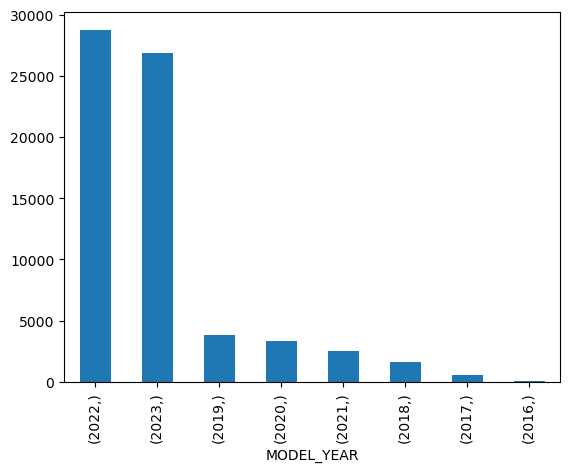

In [276]:
# get the percentage of electric vehicles in non_matched
elec_non_matched = non_matched.loc[non_matched["Fuel Type - Primary"] == "Electric", :]
print(f"The percentage of electric vehicles in the non matched is {len(elec_non_matched)/len(non_matched):.2%}")

# get the breakdown of makes and models for non_matched
display(non_matched[["MAKE", "MODEL", "MODEL_YEAR"]].value_counts().head(10))

# get the breakdown of MODEL_YEAR for non_matched, and display as a bar chart
non_matched[["MODEL_YEAR"]].value_counts().plot(kind = 'bar')

In [277]:
# Get the breakdown of makes and models for the electric vehicles
elec_non_matched[["MAKE", "MODEL", "MODEL_YEAR"]].value_counts().head(10)

MAKE     MODEL     MODEL_YEAR
TESLA    MODEL Y   2022          1444
TOYOTA   RAV4      2022           539
JEEP     WRANGLER  2022           493
HYUNDAI  IONIQ 5   2022           338
TESLA    MODEL Y   2023           320
         MODEL S   2022           314
         MODEL X   2022           204
         MODEL 3   2023           188
KIA      EV6       2022           172
FORD     F SERIES  2022           171
Name: count, dtype: int64

In [278]:
# create a copy of rlp_raw
rlp_raw_copy = rlp_raw.copy()

# Make all the column names lowercase
rlp_raw_copy.columns = rlp_raw_copy.columns.str.lower()

# Drop duplicate columns and print which columns you dropped
rlp_raw_copy = rlp_raw_copy.loc[:, ~rlp_raw_copy.columns.duplicated()]
print(f"Dropped columns: {rlp_raw.columns.duplicated().sum()}")


Dropped columns: 0


In [279]:
# Create a column in rlp_raw_copy that is 1, when the transaction price is missing, and 0 otherwise
rlp_raw_copy["transaction_price_missing"] = 1
rlp_raw_copy.loc[rlp_raw_copy["transaction_price"].notnull(), "transaction_price_missing"] = 0

# Create a column in rlp_raw_copy that is the transaction price multiplied by the veh_count
rlp_raw_copy["transaction_price_total"] = rlp_raw_copy["transaction_price"] * rlp_raw_copy["veh_count"]

# Create a column called "count_vehicles_nonmissing_price" that is equal to veh_count when transaction_price is not missing, and 0 otherwise
rlp_raw_copy["count_vehicles_nonmissing_price"] = rlp_raw_copy["veh_count"]
rlp_raw_copy.loc[rlp_raw_copy["transaction_price"].isnull(), "count_vehicles_nonmissing_price"] = 0

# Group rlp_raw_copy by year, month, make, model, model_year, zip_code, and vin_d1_match, and sum the columns "veh_count", "transaction_price" (ignore NAs), and "count_vehicles_nonmissing_price"
rlp_grouped = rlp_raw_copy.groupby(["year", "month", "make", "model", "model_year", "zip_code", "vin_d1_match"]).agg({"veh_count": "sum", "transaction_price_total": "sum", "count_vehicles_nonmissing_price": "sum"}).reset_index()
rlp_grouped["avg_transaction_price"] = rlp_grouped["transaction_price_total"] / rlp_grouped["count_vehicles_nonmissing_price"]
rlp_grouped.sort_values("count_vehicles_nonmissing_price", ascending = False).head(10)

,year,month,make,model,model_year,zip_code,vin_d1_match,veh_count,transaction_price_total,count_vehicles_nonmissing_price,avg_transaction_price
648838,2022,10,TESLA,MODEL 3,2022,6096,5YJ3E1EAN,100,5030253.0,99,50810.636364
589549,2022,4,TESLA,MODEL 3,2022,6096,5YJ3E1EAN,78,3823409.0,78,49018.064103
150885,2019,1,LAND ROVER,DISCOVERY SPORT,2019,6820,SALCR2FXK,110,1728352.0,75,23044.693333
609475,2022,6,TESLA,MODEL 3,2022,6096,5YJ3E1EAN,73,3494396.0,68,51388.176471
184135,2019,4,LAND ROVER,RANGE ROVER VELAR,2019,6820,SALYB2FVK,79,2554792.0,67,38131.223881
615459,2022,7,IC CORP,BUS,2023,6708,4DRBUC8NP,62,5165902.0,62,83321.000000
582225,2022,4,CHEVROLET,MALIBU,2022,6096,1G1ZD5STN,60,1536282.0,59,26038.677966
467011,2021,5,HYUNDAI,ELANTRA SEDAN,2021,6096,5NPLL4AGM,57,1039706.0,53,19617.094340
467015,2021,5,HYUNDAI,ELANTRA SEDAN,2021,6096,KMHLM4AGM,54,1062924.0,52,20440.846154
231560,2019,8,IC CORP,BUS,2020,6067,4DRBUC8PL,50,3896600.0,50,77932.000000


In [280]:
# Show me all entries from rlp_copy for vin_d1_match == "5YJ3E1EAN" for year 2022, month 10, and zip code 6096
rlp_raw_copy.loc[(rlp_raw_copy.vin_d1_match == "5YJ3E1EAN") & (rlp_raw_copy.year == 2022) & (rlp_raw_copy.month == 10) & (rlp_raw_copy.zip_code == 6096), :]


,year_month,make,model,model_year,transaction_price,zip_code,vin_prefix,county_name,state_abbrv,veh_count,...,manufacturer name,model year,fuel type - primary,electrification level,year,month,vin_d1_match,transaction_price_missing,transaction_price_total,count_vehicles_nonmissing_price
25621,202210,TESLA,MODEL 3,2022,49947.0,6096,5YJ3E1EA2N,HARTFORD,CT,2,...,"TESLA, INC.",2022.0,Electric,BEV (Battery Electric Vehicle),2022,10,5YJ3E1EAN,0,99894.0,2
135394,202210,TESLA,MODEL 3,2022,51447.0,6096,5YJ3E1EA2N,HARTFORD,CT,1,...,"TESLA, INC.",2022.0,Electric,BEV (Battery Electric Vehicle),2022,10,5YJ3E1EAN,0,51447.0,1
259974,202210,TESLA,MODEL 3,2022,50447.0,6096,5YJ3E1EAXN,HARTFORD,CT,1,...,"TESLA, INC.",2022.0,Electric,BEV (Battery Electric Vehicle),2022,10,5YJ3E1EAN,0,50447.0,1
309869,202210,TESLA,MODEL 3,2022,50947.0,6096,5YJ3E1EA2N,HARTFORD,CT,1,...,"TESLA, INC.",2022.0,Electric,BEV (Battery Electric Vehicle),2022,10,5YJ3E1EAN,0,50947.0,1
346179,202210,TESLA,MODEL 3,2022,51447.0,6096,5YJ3E1EA4N,HARTFORD,CT,7,...,"TESLA, INC.",2022.0,Electric,BEV (Battery Electric Vehicle),2022,10,5YJ3E1EAN,0,360129.0,7
348260,202210,TESLA,MODEL 3,2022,49947.0,6096,5YJ3E1EA4N,HARTFORD,CT,15,...,"TESLA, INC.",2022.0,Electric,BEV (Battery Electric Vehicle),2022,10,5YJ3E1EAN,0,749205.0,15
349915,202210,TESLA,MODEL 3,2022,NaN,6096,5YJ3E1EA3N,HARTFORD,CT,1,...,"TESLA, INC.",2022.0,Electric,BEV (Battery Electric Vehicle),2022,10,5YJ3E1EAN,1,NaN,0
404854,202210,TESLA,MODEL 3,2022,50947.0,6096,5YJ3E1EA4N,HARTFORD,CT,5,...,"TESLA, INC.",2022.0,Electric,BEV (Battery Electric Vehicle),2022,10,5YJ3E1EAN,0,254735.0,5
483697,202210,TESLA,MODEL 3,2022,51947.0,6096,5YJ3E1EA4N,HARTFORD,CT,2,...,"TESLA, INC.",2022.0,Electric,BEV (Battery Electric Vehicle),2022,10,5YJ3E1EAN,0,103894.0,2
576874,202210,TESLA,MODEL 3,2022,49947.0,6096,5YJ3E1EA3N,HARTFORD,CT,17,...,"TESLA, INC.",2022.0,Electric,BEV (Battery Electric Vehicle),2022,10,5YJ3E1EAN,0,849099.0,17


In [281]:
# sum the veh_count for the above
rlp_raw_copy.loc[(rlp_raw_copy.vin_d1_match == "5YJ3E1EAN") & (rlp_raw_copy.year == 2022) & (rlp_raw_copy.month == 10) & (rlp_raw_copy.zip_code == 6096), "veh_count"].sum()

# Show me all entries from rlp_copy for vin_d1_match == "5YJ3E1EAN" for year 2022, month 10, and zip code 6096
rlp_grouped.loc[(rlp_grouped.vin_d1_match == "5YJ3E1EAN") & (rlp_grouped.year == 2022) & (rlp_grouped.month == 10) & (rlp_grouped.zip_code == 6096), :]

,year,month,make,model,model_year,zip_code,vin_d1_match,veh_count,transaction_price_total,count_vehicles_nonmissing_price,avg_transaction_price
648838,2022,10,TESLA,MODEL 3,2022,6096,5YJ3E1EAN,100,5030253.0,99,50810.636364


In [282]:
# Show the entries in rlp_grouped with the lowest average transaction price
rlp_grouped.sort_values("avg_transaction_price").head(20)


,year,month,make,model,model_year,zip_code,vin_d1_match,veh_count,transaction_price_total,count_vehicles_nonmissing_price,avg_transaction_price
318208,2020,4,MAZDA,CX-5,2020,6812,JM3KFBCML,1,1.0,1,1.0
103189,2018,9,MAZDA,CX-9,2018,6840,JM3TCBDYJ,1,1.0,1,1.0
312202,2020,3,MAZDA,CX-5,2020,6810,JM3KFBDML,1,1.0,1,1.0
208649,2019,6,MAZDA,CX-9,2019,6896,JM3TCBDYK,1,1.0,1,1.0
208647,2019,6,MAZDA,CX-9,2019,6877,JM3TCBCYK,2,1.0,1,1.0
112517,2018,10,HONDA,ODYSSEY,2019,6513,5FNRL6H7K,4,1.0,1,1.0
220666,2019,7,MAZDA,6,2019,6107,JM1GL1WYK,1,1.0,1,1.0
220657,2019,7,MAZDA,3,2019,6902,JM1BPBMMK,2,1.0,1,1.0
414428,2021,1,FORD,F SERIES,2020,6790,1FTBF2B6L,2,1.0,1,1.0
208638,2019,6,MAZDA,CX-9,2019,6488,JM3TCBDYK,1,1.0,1,1.0


In [283]:
# For the top entry, show the entries in rlp_raw_copy that correspond to it
rlp_raw_copy.loc[(rlp_raw_copy.vin_d1_match == "JM3KFBDML") & (rlp_raw_copy.year == 2020) & (rlp_raw_copy.month == 3) & (rlp_raw_copy.zip_code == 6810), :]

,year_month,make,model,model_year,transaction_price,zip_code,vin_prefix,county_name,state_abbrv,veh_count,...,manufacturer name,model year,fuel type - primary,electrification level,year,month,vin_d1_match,transaction_price_missing,transaction_price_total,count_vehicles_nonmissing_price
400232,202003,MAZDA,CX-5,2020,1.0,6810,JM3KFBDM7L,FAIRFIELD,CT,1,...,MAZDA,2020.0,Gasoline,NaN,2020,3,JM3KFBDML,0,1.0,1


In [284]:
# Show entries in rlp_copy for which transaction price is very low, and a breakdown by fuel type
rlp_raw_copy.loc[rlp_raw_copy.transaction_price < 5000, "fuel type - primary"].value_counts()

# Show a breakdown of transaction prices in 5k increments for rlp_copy
rlp_raw_copy["transaction_price_bin"] = pd.cut(rlp_raw_copy["transaction_price"], bins = np.arange(0, 100000, 5000))
rlp_raw_copy["transaction_price_bin"].value_counts().sort_index()

transaction_price_bin
(0, 5000]           8572
(5000, 10000]      13433
(10000, 15000]     25662
(15000, 20000]     51645
(20000, 25000]     93902
(25000, 30000]    116521
(30000, 35000]     94652
(35000, 40000]     72494
(40000, 45000]     60502
(45000, 50000]     43977
(50000, 55000]     26589
(55000, 60000]     17356
(60000, 65000]     12451
(65000, 70000]      8379
(70000, 75000]      5542
(75000, 80000]      4290
(80000, 85000]      3568
(85000, 90000]      2554
(90000, 95000]      1785
Name: count, dtype: int64

In [285]:
# For each of the first three bins, show a breakdown by fuel type
rlp_raw_copy.loc[rlp_raw_copy["transaction_price_bin"].isin(rlp_raw_copy["transaction_price_bin"].value_counts().sort_index().index[0:3].to_list()),"fuel type - primary"].value_counts()

fuel type - primary
Gasoline                                    46735
Electric                                      476
Diesel                                        308
Flexible Fuel Vehicle (FFV)                    89
Liquefied Petroleum Gas (propane or LPG)        2
Compressed Natural Gas (CNG)                    1
Name: count, dtype: int64

In [292]:
# For those entries in rlp_copy with a transaction price lower than 15,000, get a transaction price from d1
rlp_low_price = rlp_raw_copy.loc[rlp_raw_copy.transaction_price < 15000, :]
rlp_low_price = rlp_low_price.loc[rlp_low_price.vin_d1_match.notnull(), :]
rlp_low_price = rlp_low_price.loc[rlp_low_price.vin_d1_match.isin(d1_vins_dedup.vin_rlp_match), :]
rlp_low_price = rlp_low_price.merge(d1_vins_dedup, how = 'left', left_on = 'vin_d1_match', right_on = "vin_rlp_match")

In [287]:
# Is there a price column in the d1 dataset?
d1_vins_dedup.columns

Index(['vin_id', 'vehicle_id', 'vin_pattern', 'year', 'make', 'model', 'trim',
       'style', 'mfr_model_num', 'mfr_package_code', 'doors', 'drive_type',
       'vehicle_type', 'rear_axle', 'body_type', 'body_subtype', 'bed_length',
       'engine_id', 'engine_name', 'engine_size', 'engine_block',
       'engine_cylinders', 'engine_valves', 'engine_induction',
       'engine_aspiration', 'engine_cam_type', 'fuel_type', 'trans_id',
       'trans_name', 'trans_type', 'trans_speeds', 'wheelbase',
       'gross_vehicle_weight_range', 'restraint_type', 'brake_system',
       'country_of_mfr', 'plant', 'd1_merge', 'vin_rlp_match', 'veh_price_id',
       'msrp', 'invoice', 'dest', 'gas_guzzler_tax'],
      dtype='object')

# New RLP Data

In [22]:
new_rlp = pd.read_table(rlpolk_data_path / "new" / "US_Yale_University_OP0001635118_NV_MA_CT_By_Zip_202310.txt", sep="|", header= 0)

In [19]:
# make column names lower case
new_rlp.columns = new_rlp.columns.str.lower()

# split REPORT_YEAR_MONTH into two separate columns
new_rlp["year"] = new_rlp["report_year_month"].astype(str).str[0:4].astype(int)
new_rlp["month"] = new_rlp["report_year_month"].astype(str).str[4:6].astype(int)

# Extract only entries for Connecticut
new_rlp_ct = new_rlp[new_rlp["state_abbrv"] == "CT"]


,report_year_month,make,model,model_year,transaction_price,zip_code,state_abbrv,veh_count,year,month
0,202102,RAM,PROMASTER,2021,NaN,6371,CT,2,2021,2
1,202201,FORD,ESCAPE,2022,NaN,6410,CT,1,2022,1
2,201909,FORD,TRANSIT CONNECT VAN,2019,25100.0,6032,CT,1,2019,9
3,202304,JEEP,GRAND CHEROKEE,2023,NaN,6032,CT,1,2023,4
5,202305,CHEVROLET,SILVERADO,2023,48908.0,6023,CT,1,2023,5
...,...,...,...,...,...,...,...,...,...,...
1806321,201903,SUBARU,IMPREZA,2019,27374.0,6902,CT,1,2019,3
1806322,201902,MAZDA,CX-5,2019,29393.0,6902,CT,1,2019,2
1806324,202310,SUBARU,FORESTER,2023,30951.0,6066,CT,1,2023,10
1806326,201912,SUBARU,IMPREZA,2019,23967.0,6457,CT,1,2019,12


In [21]:
# Show which years are available
new_rlp_ct.columns

# What are the lengths of t

Index(['report_year_month', 'make', 'model', 'model_year', 'transaction_price',
       'zip_code', 'state_abbrv', 'veh_count', 'year', 'month'],
      dtype='object')

In [16]:
# Show 10 entries where the state is CT
new_rlp.loc[:, "state_abbrv"].unique()

array(['VA', 'OK', 'NC', 'TX', 'FL', 'NY', 'NJ', 'OH', 'CA', 'MA', 'IL',
       'MI', 'PA', 'GA', 'AZ'], dtype=object)

# View EV Characteristics Downloaded from NHTSA to check completeness

In [288]:
ev_chars = pd.read_csv(rlpolk_data_path / "rlp_ev_characteristics_012624.csv", index_col = [0])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rrn22/Documents/tobin_working_data/rlpolk_data/rlp_ev_characteristics_012624.csv'

In [ ]:
ev_chars.columns

In [ ]:
evs_only_tomerge = evs_only.loc[:, ~evs_only.columns.isin(ev_chars.columns[0:len(ev_chars.columns)-1])]

In [ ]:
evs_only_chars = evs_only_tomerge.merge(ev_chars, how = 'left', on='vin_corrected')

In [ ]:
ev_notna_summary = evs_only_chars.loc[:, evs_only_chars.columns.isin(ev_chars.columns)]
ev_notna_summary = pd.DataFrame(ev_notna_summary.notna().sum()).reset_index().rename({0: "Count"}, axis = 1)
ev_notna_summary["Percentage"] = ev_notna_summary["Count"]/len(evs_only)

In [ ]:
ev_notna_summary.sort_values("Count", ascending = False).head(70)

,index,Count,Percentage
0,vin_corrected,29592,1.000000
122,Custom Motorcycle Type,27885,0.942315
124,Motorcycle Chassis Type,27885,0.942315
123,Motorcycle Suspension Type,27885,0.942315
9,Manufacturer Name,27885,0.942315
11,Model Year,27885,0.942315
15,Vehicle Type,27885,0.942315
8,Make,27885,0.942315
6,Vehicle Descriptor,27885,0.942315
40,Trailer Body Type,27885,0.942315


In [ ]:
vars_of_interest = ["vin_corrected", "Make", "Vehicle Type", "Fuel Type - Primary",
                    "Gross Vehicle Weight From", "Doors", "Number of Seats", "Curb Weight (pounds)",
                    "Transmission Style", "Wheel Base (inches) From", "Engine Brake (hp) From", "Displacement (CI)"]

ev_notna_keyvars = ev_notna_summary.loc[ev_notna_summary["index"].isin(vars_of_interest), :].reset_index(drop = True).sort_values("Percentage", ascending = False)

In [ ]:
ev_notna_keyvars

,index,Count,Percentage
0,vin_corrected,29592,1.000000
1,Make,27885,0.942315
2,Vehicle Type,27885,0.942315
9,Fuel Type - Primary,27800,0.939443
3,Doors,26415,0.892640
6,Number of Seats,21723,0.734084
7,Transmission Style,20834,0.704042
5,Wheel Base (inches) From,13680,0.462287
10,Engine Brake (hp) From,10550,0.356515
8,Displacement (CI),8882,0.300149


In [ ]:
print(ev_notna_keyvars.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
index & Count & Percentage \\
\midrule
vin_corrected & 29592 & 1.000000 \\
Make & 27885 & 0.942315 \\
Vehicle Type & 27885 & 0.942315 \\
Fuel Type - Primary & 27800 & 0.939443 \\
Doors & 26415 & 0.892640 \\
Number of Seats & 21723 & 0.734084 \\
Transmission Style & 20834 & 0.704042 \\
Wheel Base (inches) From & 13680 & 0.462287 \\
Engine Brake (hp) From & 10550 & 0.356515 \\
Displacement (CI) & 8882 & 0.300149 \\
Curb Weight (pounds) & 366 & 0.012368 \\
\bottomrule
\end{tabular}

